# __Detecting credit card fraud through transaction time__ 

*Our objective in this notebook is to detect whether or not a credit card transaction is fraudulent, given parameters such as the time between transactions, transaction amount, and some obfuscated columns.*


# Table of Contents 
1. [Background](#Background)
2. [Data ingestion](#Data-ingestion)
3. [Data preprocessing](#Data-preprocessing)
4. [Exploratory Data Analysis](#EDA)
5. [Model Training](#Model-Training)
6. [Testing the Model](#Testing-the-Model)
7. [Conclusion](#Conclusion)
8. [Credits](#Credits)

# Background

### Purpose  

If you work at a bank, millions of fraudulent transactions occur every day. According to [Forbes](https://www.forbes.com/sites/rogeraitken/2016/10/26/us-card-fraud-losses-could-exceed-12bn-by-2020/#51e7f64ad243), U.S. card issuers and merchants could lose over $12 billion in 2020 due to fraud. With this model, even with a generic public dataset, we can accurately detect fraud with a minimum of 92% accuracy.  

Utilizing machine learning technology, Cocolevio can create custom fraud detection models for banks or financial institutions, allowing both companies and cardholders alike to rest easy with an additional layer of security to protect their finances. 

### Introduction

   In this notebook, I used a public dataset from Kaggle. You can download and use the dataset [HERE](https://www.kaggle.com/mlg-ulb/creditcardfraud). Thanks to the ULB Machine Learning Group for providing and doing preprocessing for this dataset.
   
The first step will be observing our data and understanding what we're dealing with. Second, we will "clean" the dataset, dropping empty values and scaling where needed. Third, we will balance our dataset to get reliable predictions for fraudulent and non-fraudulent transactions. Fourth, we will build and train a model to help us predict outcomes. 

For this notebook, we are given some columns: Time, V1-V28, Amount, and Class.  

**Time** corresponds to the seconds between each transaction
and the subsequent transaction made by the user.  

**V1-V28** are obfuscated columns pertaining to personal data and additional features that may contain sensitive information. The data values for these columns were produced through an obfuscation process. For security reasons, we cannot backtrack these numbers to any values that would make sense to us, so our model will only be specific to the non-sensitive data here. However, we can still show that we can create an accurate model for this use case. 

**Amount** refers to the transaction amount.  

**Class** is 1 for fraudulent transaction and 0 otherwise.  

# Data ingestion

### Initial thoughts


   According to the author of the dataset, the distribution of transactions is heavily skewed for nonfradualent transactions. While there are only 492 fraudulent transactions, there are 284,315 nonfraudulent transactions. This is not a good balance, and we will rectify this situation during the data preprocessing stage. If we leave the balance heavily skewed towards not fraud, our model will rarely ever predict a transaction as fraudulent. Since there are only two options for a transaction (fraud/not fraud), we want the distribution in our dataset to be as close to equal as possible.  
   
   Removing a significant amount of values will also affect our model and has its own disadvantages. Since we will be significantly reducing our number of training points, our accuracies may be skewed too high because of it.  

   Unfortunately, adding to this dataset is not possible, as we do not know all of the original feaetures and attributes contained (V1-V28). 

# Data preprocessing

The purpose of the data preprocessing stage is to minimize potential error in the model as much as possible. Generally, a model is only as good as the data passed into it, and the data preprocessing we do ensures that the model has as accurate a dataset as possible. While we cannot perfectly clean the dataset, we can at least follow some basics steps to ensure that our dataset has the best possible chance of generating a good model. 

First, let's check and see null values for this dataset. Null values are empty, useless entries within our dataset that we don't need. If we skip removing null values, our model will be inaccurate as we create "connections" for useless values, rather than focusing all resources onto creating connections for useful values. 

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('datasets/creditcard.csv')

In [2]:
print("Presence of null values: " + str(df.isnull().values.any()))

Presence of null values: False


Now that we've confirmed there are no null values, we can see what the distribution really looks like between the fraudulent and nonfraudulent transactions. 

In [3]:
not_fraud_df = df[df['Class'] == 0]
fraud_df = df[df['Class'] == 1]

print("Number of nonfraudulent transactions: " + str(len(not_fraud_df.index)))
print("Number of fraudulent transactions: " + str(len(fraud_df.index)))

Number of nonfraudulent transactions: 284315
Number of fraudulent transactions: 492


So this is the first major hurdle of preprocessing this dataset. Building a model with that fraudulent vs non-fraudulent distribution is very difficult, because our model will predict significantly more non-fraudulent transactions since there is such an uneven distribution.   
  
  Having too few data points means that our model training will be much shorter, so that we won't be able to establish as many connections as we had before to improve our results. Since our testing size is also significantly smaller, our accuracy is also affected since we won't have a large enough test set.  
  
  However, not equalizing the distributions makes our model practically useless due to the tremendous difference in size of the not-fraud compared to the fraud.  
  
  So, let's start by equalizing the number of fraud and not-fraud transactions. This will allow for better prediction since the model will be trained to expect fraud and not-fraud with equal chance, since it is a binary outcome. 

If we had left the distribution as is, the model would be heavily skewed towards non-fraud, and the data from 492 frauds would have almost no effect on the model at all.

### Equalization of data between fraudulent and non-fraudulent

Now, we're going to equalize the number of fraudulent and non-fraud transactions. Let's start by extracting 492 non-fraudulent transactions at random. 

In [4]:
not_fraud_df = df.loc[df['Class'] == 0][:492]
equalized_df = pd.concat([fraud_df, not_fraud_df])
equalized_df = equalized_df.sample(frac = 1, random_state = 42)
not_fraud_df = equalized_df[equalized_df['Class'] == 0]
fraud_df = equalized_df[equalized_df['Class'] == 1]

print("Number of nonfraudulent transactions: " + str(len(not_fraud_df.index)))
print("Number of fraudulent transactions: " + str(len(fraud_df.index)))

Number of nonfraudulent transactions: 492
Number of fraudulent transactions: 492


Now that we've equalized the number of fraudulent and non-fraudulent transactions, we should normalize all of the column values in order to best identify features in the dataset. In doing so, we minimize inaccuracies in having large values that may skew results.

Normalizaton is a process by which we scale values to be between specified limits, usually -1 to 1 or 0 to 1. This process is important because our machine learning models are heavily affected by differences in number size. The difference between 200 and 1 will cause massive inaccuracies in our model compared to the difference between 1 and 0.1. Normalization helps us to eliminate these sources of error rather than having it propagate throughout our analysis. 

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(equalized_df['Time'].values.reshape(-1, 1))
equalized_df['Time'] = scaler.fit_transform(equalized_df['Time'].values.reshape(-1, 1))
scaler.fit(equalized_df['Amount'].values.reshape(-1, 1))
equalized_df['Amount'] = scaler.fit_transform(equalized_df['Amount'].values.reshape(-1, 1))

With this scaling done, we can now begin analyzing the dataset for potential features to train on.  

In the next section, we'll be performing Exploratory Data Analysis (EDA) on the dataset.

# EDA

The purpose of EDA is to enhance our understanding of trends in the dataset without involving complicated machine learning models. Oftentimes, we can see obvious traits using graphs and charts just from plotting columns of the dataset against each other.

We've completed the necessary preprocessing steps, so let's create a correlation map to see the relations between different features.  

A correlation map (or correlation matrix) is a visual tool that illustrates the relationship between different columns of the dataset. The matrix will be lighter when the columns represented move in the same direction together, and it will be darker when one column decreases while the other increases. Strong spots of light and dark spots in our correlation matrix tell us about the future reliabilty of the model. 

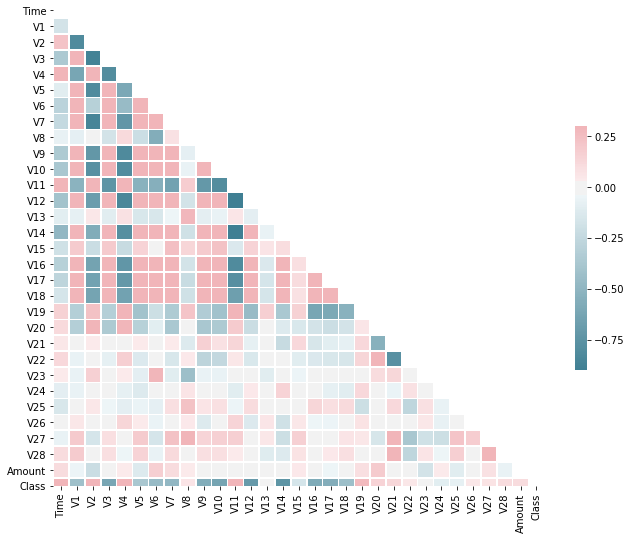

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_corr(df):
    corr=df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

plot_corr(equalized_df)


From these column values, we can see that there are some very useful correlations present within our new dataset. The Class (meaning fraud or not-fraud) is heavily correlated with the Time (seconds between each transaction) but is negatively correlated with V3, V5-V7, V15-V18, etc. While this doesn't tell us anything specific, it does show that the data has trends we can use to improve the accuracy of our model. 

Let's also plot a pie chart of the distribution between fraud and not-fraud for easier viewing.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002290517D188>,
      dtype=object)

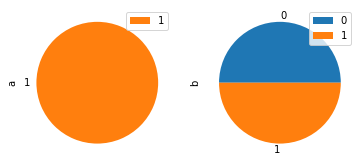

In [7]:
import matplotlib.pyplot as plt

not_fraud = len(equalized_df[equalized_df['Class'] == 0].values)
fraud = len(equalized_df[equalized_df['Class'] == 1].values)

pie_chart = pd.DataFrame({'a': [0, 1],'b': [not_fraud, fraud]})
pie_chart.plot.pie(subplots=True)

As you can see in the pie chart above, the distribution between fraud and not fraud is equal, which means our code snippets for the equalization were successful.  

Normally, the EDA section is where we use traditional statistical analysis techniques, rather than machine learning, to gain insights about our dataset. For example, had we known the V1-V28 columns as something like 'Store' or 'Region', EDA would tell us how much attributes like those contribute to fraud. 

# Model Training

In this section, we will be creating and training our model for predicting whether a transaction is fraudulent or not. Since there are multiple algorithms we can use to build our model, we will compare the accuracy scores after testing and pick the most accurate algorithm.

For my own use, I exported the normalized, equal parts fraud and not-fraud data to a .csv file called _"cleaned credit card.csv_". You can use the code below to do this, or you can use the _equalized df_ generated earlier to provide the same functionality.  

In [8]:
equalized_df.to_csv('datasets/cleaned credit card.csv')

Let's begin by importing the different models we will be using for classification. 

In [9]:
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

From this list, we are using XGBoost, DecisionTree, RandomForest, Naive Bayes, LogisticRegressoin, SVC, and KNeighborsClassifier to perform our predictions. We will then see which algorithm produces the highest accuracy and select it as our algorithm of choice for future use. We also want to partition our dataset into training, testing, and validation, so let's add a method for that ability. 

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Now, we can begin building and training our model.

Let's perform the splitting of our data into test, train, validation using train_test_split.  

Our testing will take three phases: testing, training, and validation. Training is first, and it's where our model generates "intuition" about how to approach fraudulent and not fraudulent transactions. It is similar to a student studying and developing knowledge about a topic before an exam.  

The testing phase is where we see how the model performs against data where we know the outcome. This would be the exam if we continue the analogy from before. The algorithms will perform differently, similar to how students will score differently on the exam. From this phase, we generate an accuracy score to compare the different algorithms.  

The validation testing is how we check that the model isn't overfitting to our specific dataset. Overfitting is when the model starts to develop an intuition that is too specific to the training set. Overfitting is a problem because our model is no longer flexible. It may work on the initial set, but subsequent uses will cause our model to fail. Continuing the exam analogy, the validation testing phase is like another version of the exam with different questions. If a student happened to cheat on the first exam by knowing the questions, the second exam will give a better representation of performance.  

Note that verification doesn't completely disprove or prove overfitting, but the testing does give insight about it. 

In [11]:
training,test = train_test_split(equalized_df, train_size = 0.7, test_size = 0.3, shuffle=True)
training, valid = train_test_split(training, train_size = 0.7, test_size =0.3, shuffle=True) 

training_label = training.pop('Class')
test_label = test.pop('Class')
valid_label = valid.pop('Class')

We assign the 'Class' column to be our label as that is what we are trying to classify by. Our training and testing will use these labels to compare the predicted output versus the actual output. 

In [12]:
import pprint

pp = pprint.PrettyPrinter(indent=4)

# instantiate the algorithms
xgb = XGBClassifier()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
nbc = GaussianNB()
LR = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
SVM = SVC(kernel='rbf', C=1,gamma='auto')
knn = KNeighborsClassifier(n_neighbors=3)

# train the models
xgb.fit(training, training_label)
dtc.fit(training, training_label)
rfc.fit(training, training_label)
nbc.fit(training, training_label)
LR.fit(training, training_label)
SVM.fit(training, training_label)
knn.fit(training, training_label)

# try and predict an outcome from the test set
xgb_predict = xgb.predict(test)
dtc_predict = dtc.predict(test)
rfc_predict = rfc.predict(test)
nbc_predict = nbc.predict(test)
LR_predict = LR.predict(test)
SVM_predict = SVM.predict(test)
knn_predict = knn.predict(test)

# judge accuracy using built-in function 
accuracy = dict()
accuracy['XGBoost'] = accuracy_score(test_label, xgb_predict)
accuracy['Naive_bayes'] = accuracy_score(test_label, nbc_predict)
accuracy['DecisionTree'] = accuracy_score(test_label, dtc_predict)
accuracy['RandomForest'] = accuracy_score(test_label,rfc_predict)
accuracy['support_vector_Machines'] = accuracy_score(test_label,SVM_predict)
accuracy['Linear Regression'] = accuracy_score(test_label,LR_predict)
accuracy['KNN'] = accuracy_score(test_label,knn_predict)

c:\cocolevio\5411_alpha\ffea_notebooks\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The accuracies for the different algorithms are shown below, sorted by algorithm name and then its decimal accuracy:

In [13]:
pp.pprint(accuracy)

{   'DecisionTree': 0.9932432432432432,
    'KNN': 0.9493243243243243,
    'Linear Regression': 0.9797297297297297,
    'Naive_bayes': 0.9797297297297297,
    'RandomForest': 0.9864864864864865,
    'XGBoost': 0.9932432432432432,
    'support_vector_Machines': 0.9290540540540541}


From the preliminary testing, we can see that all of the algorithms are above 90% accuracy. While this is good, we also must test for overfitting our model with the data we have. So, we avoid this overfitting by testing with a validation set. If the validation set accuracy is also high, we can be slightly more confident that our model isn't overfitting.  

However, it appears as if XGBoost and DecisionTree are performing the best with a perfect score on the testing set.

# Testing the Model

After performing the training tests, let's perform validation tests to see if the model is overfitting to our test data. 

In [14]:
# perform validation testing for dataset
xgb_predict = xgb.predict(valid)
dtc_predict = dtc.predict(valid)
rfc_predict = rfc.predict(valid)
nbc_predict = nbc.predict(valid)
LR_predict = LR.predict(valid)
SVM_predict = SVM.predict(valid)
knn_predict = knn.predict(valid)

In the below code snippet, we will store the accuracies for all the algorithms and look for the highest accuracy prediction to use for our model. 

In [15]:
# judge accuracy using built-in function
accuracy['XGBoost'] = accuracy_score(valid_label, xgb_predict) 
accuracy['Naive_bayes'] = accuracy_score(valid_label, nbc_predict)
accuracy['DecisionTree'] = accuracy_score(valid_label, dtc_predict)
accuracy['RandomForest'] = accuracy_score(valid_label,rfc_predict)
accuracy['support_vector_Machines'] = accuracy_score(valid_label,SVM_predict)
accuracy['Linear Regression'] = accuracy_score(valid_label,LR_predict)
accuracy['KNN'] = accuracy_score(valid_label,knn_predict)

The accuracies for the validation testing are below, in the same format as the testing set:

In [16]:
pp.pprint(accuracy)

{   'DecisionTree': 1.0,
    'KNN': 0.9516908212560387,
    'Linear Regression': 0.9710144927536232,
    'Naive_bayes': 0.9758454106280193,
    'RandomForest': 0.9903381642512077,
    'XGBoost': 1.0,
    'support_vector_Machines': 0.9468599033816425}


These accuracies are extremely high as well. Even though we did validation testing, there can still be a chance that the model is overfitting to our test dataset. So, in the future, we must be more aware of this issue.

Because we also cut down so many of our data points to equalize the fraud/not fraud distribution, our model is predicting on very few points, meaning that we should assume a minimum accuracy of 90% and go forward. 

In [17]:
max_accuracy = max(accuracy,key=accuracy.get)
pp.pprint("Most accurate algorithm is: " + str(max_accuracy))

'Most accurate algorithm is: XGBoost'


For this dataset, XGBoost, RandomForest, and DecisionTree are the highest accuracy classifiers, so we will use them for future classification tasks. The specific algorithm depends on what you prioritize the most: speed, accuracy, or resources. These algorithms all specialize in these different fields, so choosing one requires in-depth knowledge on what a company prioritizes most for their use case. 

Overall though, we can see that, even with data that is obfuscated, we can perform reliable fraud detection using very little fraud/non-fraud data. 

# Conclusion
During this notebook, we built a model that could accurately detect fraudulent transactions with at least 92% accuracy from our normal and validation testing. This model has many valid real-world use cases. For example, a bank could take a similar approach and reduce the amount of money spent trying to detect fraud by automating it with a machine. Our model could also save the consumer a lot of time and money by having an extra layer of security for lost cards and stolen items.   

Overall, while the model may be susceptible to overfitting, we have shown that is it possible to reliably detect credit card fraud. We can protect consumers with this technology by having a similar model integrated into the transaction process to notify the consumer and bank of fraud within minutes, rather than days. 

If you're a banker looking to stop losing money to fraud, Cocolevio's machine learning models can help you stop fraud before it affects your business. 

# Credits

Thanks to the Machine Learning Group at ULB once again for providing the dataset, and Kaggle for hosting it. Thanks to the many Kagglers out there who have taught me a lot of about data science. 